In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from dataset import BackendJsonDataset, BackendDataset

from tqdm import tqdm

In [21]:
DATA_PATH = "./data_revised.json"

raw_data = BackendJsonDataset(DATA_PATH)
game_ids = raw_data.get_game_ids()
game_ids

['2195', '1773', '1802', '2516']

In [22]:
data = raw_data.get_all_dfs()
data.keys()

dict_keys(['X', 't', 'y', 'errors'])

In [23]:
len(data["X"])

573

In [24]:
len(data["errors"])
# error means no login records

1865

In [25]:
dataset = BackendDataset(data)

In [26]:
dataset[0]
# X, t, y

(tensor([[ 0.7818,  0.6235,  0.0000,  1.0000,  0.0000],
         [ 0.7818,  0.6235,  0.2588,  0.9659,  0.0000],
         [ 0.7818,  0.6235,  0.5000,  0.8660,  0.0000],
         ...,
         [ 0.0000,  1.0000, -0.7071,  0.7071,  0.0000],
         [ 0.0000,  1.0000, -0.5000,  0.8660,  0.0000],
         [ 0.0000,  1.0000, -0.2588,  0.9659,  0.0000]]),
 tensor(1.),
 tensor(0.))

In [27]:
for v in dataset[0]:
    print(v.shape)

torch.Size([336, 5])
torch.Size([])
torch.Size([])


In [28]:
train_dl = DataLoader(dataset, batch_size=16, shuffle=True)

In [29]:
from model import UpliftWrapperForRNN, DirectUpliftLoss, RNNEmbedding

In [30]:
OUT_FEATURES = 64
rnn = RNNEmbedding(
    in_features=5, 
    hidden_size=16, 
    out_features=OUT_FEATURES, 
    num_layers=2, 
    dropout=0.2, 
    bidirectional=False
)

In [31]:
model = UpliftWrapperForRNN(rnn, OUT_FEATURES)

In [32]:
batch = next(iter(train_dl))
for v in batch:
    print(v.shape)

torch.Size([16, 336, 5])
torch.Size([16])
torch.Size([16])


In [33]:
x = batch[0]
t = batch[1]

out = model(x, t)

In [34]:
out["uplift"]

tensor([-0.0045, -0.0046, -0.0050, -0.0051, -0.0049, -0.0049, -0.0050, -0.0044,
        -0.0044, -0.0048, -0.0045, -0.0044, -0.0050, -0.0045, -0.0048, -0.0050],
       grad_fn=<SubBackward0>)

In [35]:
out["pred"]

tensor([0.4899, 0.4917, 0.4864, 0.4914, 0.4870, 0.4918, 0.4869, 0.4916, 0.4913,
        0.4871, 0.4916, 0.4906, 0.4870, 0.4906, 0.4875, 0.4911],
       grad_fn=<SWhereBackward>)

In [36]:
out["uplift"].shape, out["pred"].shape

(torch.Size([16]), torch.Size([16]))

In [37]:
criterion = DirectUpliftLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [38]:
NUM_EPOCHS = 20
CUTOFF = 0.2
# cutoff value must depend on the proportion of Y = 1

train_losses = []
train_accuracies = []

for epoch in range(NUM_EPOCHS):
    print(f"epoch: {epoch}")

    train_answ = []
    train_pred = []

    model.train()

    for X, t, y in tqdm(train_dl):
        optimizer.zero_grad()
        train_answ.extend(y.numpy().tolist())
        
        out = model(X, t)
        loss = criterion(out, t, y)
        loss.backward()
        train_losses.append(loss.item())

        optimizer.step()

        # needs to carefully set cutoff!!!
        pred = np.where(out["pred"].detach().numpy() > CUTOFF, 1, 0)
        train_pred.extend(pred.tolist())

    train_answ = np.array(train_answ)
    train_pred = np.array(train_pred)

    train_accuracies.append(np.sum(train_answ == train_pred)/len(train_answ))
    print(f"train accuracy: {train_accuracies[-1]}, train f1: {f1_score(train_answ, train_pred)}")

    print()

  0%|          | 0/36 [00:00<?, ?it/s]

epoch: 0


  0%|          | 0/36 [00:00<?, ?it/s]

train accuracy: 0.193717277486911, train f1: 0.32456140350877194

epoch: 1


  0%|          | 0/36 [00:00<?, ?it/s]

train accuracy: 0.5514834205933682, train f1: 0.23738872403560832

epoch: 2


  0%|          | 0/36 [00:00<?, ?it/s]

train accuracy: 0.6230366492146597, train f1: 0.2894736842105263

epoch: 3


  0%|          | 0/36 [00:00<?, ?it/s]

train accuracy: 0.5462478184991274, train f1: 0.3010752688172043

epoch: 4


  0%|          | 0/36 [00:00<?, ?it/s]

train accuracy: 0.6038394415357766, train f1: 0.31419939577039274

epoch: 5


  0%|          | 0/36 [00:00<?, ?it/s]

train accuracy: 0.6719022687609075, train f1: 0.2824427480916031

epoch: 6


  0%|          | 0/36 [00:00<?, ?it/s]

train accuracy: 0.7469458987783595, train f1: 0.3722943722943723

epoch: 7


  0%|          | 0/36 [00:00<?, ?it/s]

train accuracy: 0.7574171029668412, train f1: 0.46332046332046334

epoch: 8


  0%|          | 0/36 [00:00<?, ?it/s]

train accuracy: 0.6265270506108203, train f1: 0.3592814371257485

epoch: 9


  0%|          | 0/36 [00:00<?, ?it/s]

train accuracy: 0.8516579406631762, train f1: 0.5454545454545455

epoch: 10


  0%|          | 0/36 [00:00<?, ?it/s]

train accuracy: 0.8150087260034904, train f1: 0.5350877192982457

epoch: 11


  0%|          | 0/36 [00:00<?, ?it/s]

train accuracy: 0.3717277486910995, train f1: 0.3706293706293707

epoch: 12


  0%|          | 0/36 [00:00<?, ?it/s]

train accuracy: 0.5898778359511344, train f1: 0.19795221843003413

epoch: 13


  0%|          | 0/36 [00:00<?, ?it/s]

train accuracy: 0.518324607329843, train f1: 0.2620320855614973

epoch: 14


  0%|          | 0/36 [00:00<?, ?it/s]

train accuracy: 0.45898778359511344, train f1: 0.2922374429223744

epoch: 15


  0%|          | 0/36 [00:00<?, ?it/s]

train accuracy: 0.5846422338568935, train f1: 0.2222222222222222

epoch: 16


  0%|          | 0/36 [00:00<?, ?it/s]

train accuracy: 0.4293193717277487, train f1: 0.29978586723768735

epoch: 17


  0%|          | 0/36 [00:00<?, ?it/s]

train accuracy: 0.48342059336823734, train f1: 0.3018867924528302

epoch: 18


  0%|          | 0/36 [00:00<?, ?it/s]

train accuracy: 0.6108202443280978, train f1: 0.25418060200668896

epoch: 19


100%|██████████| 36/36 [00:12<00:00,  2.83it/s]

train accuracy: 0.38917975567190227, train f1: 0.3137254901960784



In [39]:
# Predicting uplift scores
y_true = []
y_pred = []
y_prob = []
u_pred = []

model.eval()

for X, t, y in tqdm(train_dl):
    out = model(X, t)
    pred = np.where(out["pred"].detach().numpy() > 0.5, 1, 0)
    
    y_true.extend(y.tolist())
    y_prob.extend(out["pred"].detach().numpy().tolist())
    y_pred.extend(pred.tolist())
    u_pred.extend(out["uplift"].tolist())

100%|██████████| 36/36 [00:05<00:00,  6.95it/s]


In [40]:
sum(y_true)/len(y_true)

0.193717277486911

In [41]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true, y_pred)

array([[462,   0],
       [111,   0]])

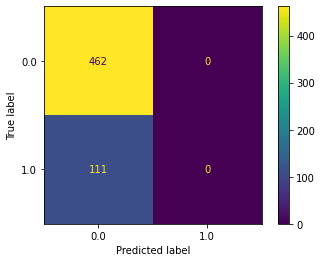

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.show()

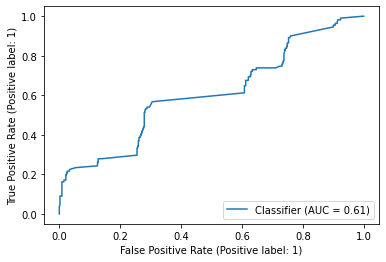

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_true, y_prob)
plt.show()

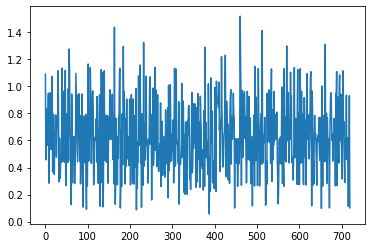

In [44]:
plt.plot(train_losses)

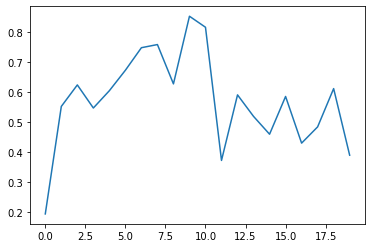

In [45]:
plt.plot(train_accuracies)

(array([210.,  10.,   2.,   1.,   1., 264.,  71.,   7.,   4.,   3.]),
 array([0.13855302, 0.14701303, 0.15547304, 0.16393306, 0.17239307,
        0.18085308, 0.18931309, 0.1977731 , 0.20623311, 0.21469312,
        0.22315313]),
 <BarContainer object of 10 artists>)

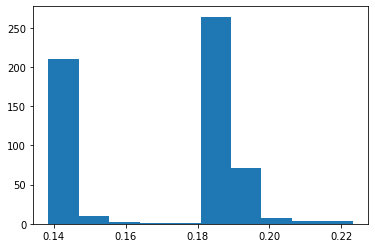

In [46]:
plt.hist(y_prob)

(array([  2.,   2.,   2.,   3.,   3.,   9.,  18., 124.,  95., 315.]),
 array([-0.05237092, -0.05155827, -0.05074561, -0.04993296, -0.0491203 ,
        -0.04830765, -0.047495  , -0.04668234, -0.04586969, -0.04505703,
        -0.04424438]),
 <BarContainer object of 10 artists>)

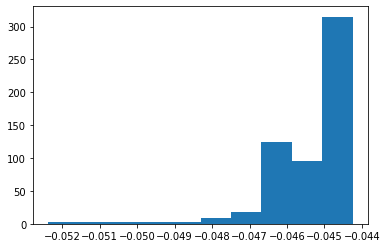

In [47]:
plt.hist(u_pred)